# Assignment 5: Tạo ảnh panorama sử dụng đặc trưng cục bộ. 

Trong phần thực hành trên lớp các bạn đã sử dụng Stitcher class để ghép ảnh. Bài tập về nhà yêu cầu các bạn viết lại phương pháp tạo ảnh Panorama mà không sử dung Sticher.

Các bước cơ bản như sau:

- Tính các đặc trưng tương đồng giữa 2 ảnh
- So khớp giữa các tập đặc trưng đó
- Ghép 2 ảnh dựa trên các cạp đã được sơ khớp: tìm phép biến đổi giữa ảnh này với ảnh kia và thực hiện ghép 2 ảnh dựa trên phép biến đổi này


In [3]:
from IPython.display import Image
from skimage.feature import hog

import skimage
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import imutils

## Hàm tìm các điểm keypoint và tính các đặc trưng cục bộ

In [23]:
def detectAndDescribe(image):
     ### YOUR CODE HERE
        
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect and extract features from the image
    #descriptor = cv2.xfeatures2d.SIFT_create()
    descriptor = cv2.SIFT_create() 
    
    (kps, features) = descriptor.detectAndCompute(image, None)

    ### YOUR CODE HERE
    
    # convert the keypoints from KeyPoint objects to NumPy arrays
    kps = np.float32([kp.pt for kp in kps])

    # return a tuple of keypoints and features
    return (kps, features)

## Hàm so khớp 2 tập đặc trưng cục bộ 

In [26]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
    ## tìm các cặp đặc trưng so khớp tốt
    ### YOUR CODE HERE
    
    # compute the raw matches and initialize the list of actual matches
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []

    # loop over the raw matches
    for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    ### YOUR CODE HERE
    
    ## tìm biến đổi Homography tương ứng giữa 2 tập điểm được so khớp
    # computing a homography requires at least 4 matches
    if len(matches) > 4:
        ### YOUR CODE HERE
        # construct the two sets of points
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])

        # compute the homography between the two sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        ### YOUR CODE HERE
        
        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status)

    # otherwise, no homograpy could be computed
    return None

## Hàm trực quan hóa kết quả so khớp

In [29]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

    # return the visualization
    return vis

## Hàm ghép cặp

In [32]:
def stitch(images, ratio=0.75, reprojThresh=4.0, showMatches=False):
    # unpack the images, then detect keypoints and extract
    # local invariant descriptors from them
    ### YOUR CODE HERE
    (imageB, imageA) = images
    (kpsA, featuresA) = detectAndDescribe(imageA)
    (kpsB, featuresB) = detectAndDescribe(imageB)
    ### YOUR CODE HERE

    # match features between the two images
    M = matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

    # if the match is None, then there aren't enough matched
    # keypoints to create a panorama
    if M is None:
        return None

    # otherwise, apply a perspective warp to stitch the images
    # together
    (matches, H, status) = M
    ### YOUR CODE HERE (see cv2.warpPerspective() function)
    result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
    result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
    ### YOUR CODE HERE

    # check to see if the keypoint matches should be visualized
    if showMatches:
        vis = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)

        # return a tuple of the stitched image and the
        # visualization
        return (result, vis)

    # return the stitched image
    return result

## Kết quả thử nghiệm trên ảnh cụ thể

In [35]:
#imageA = cv2.imread('./panorama/mountain1_left.png')
#imageB = cv2.imread('./panorama/mountain1_right.png')

imageA = cv2.imread('./panorama/sedona_left.png')
imageB = cv2.imread('./panorama/sedona_right.png')

# stitch the images together to create a panorama
(result, vis) = stitch([imageA, imageB], showMatches=True)

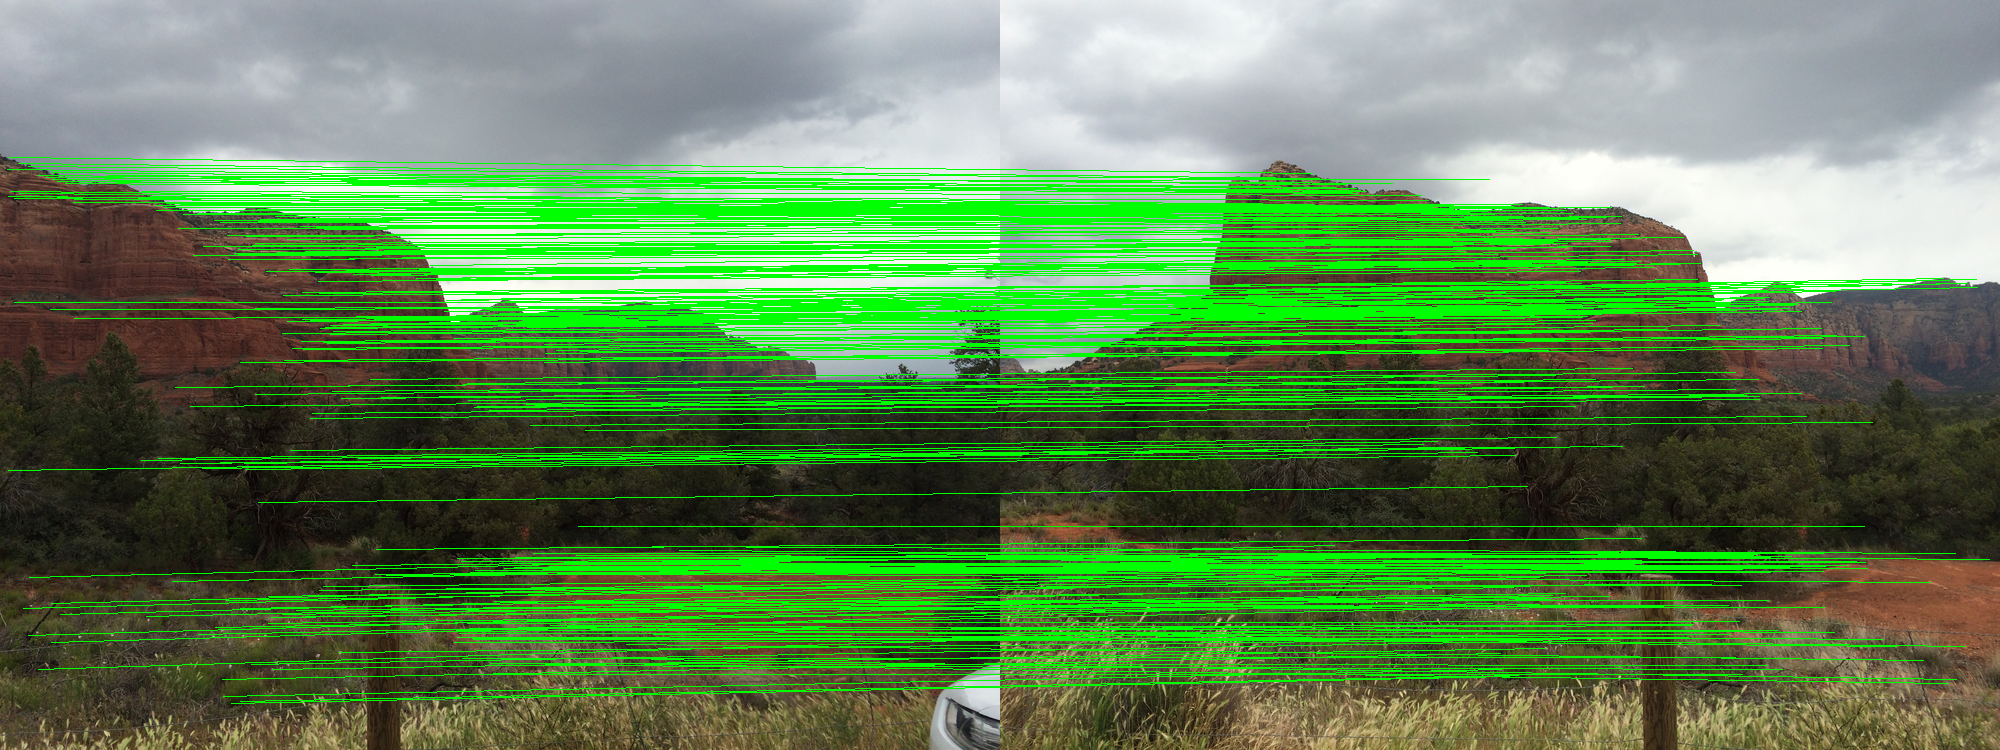

In [37]:
cv2.imwrite('matching.png', vis)
Image('matching.png')

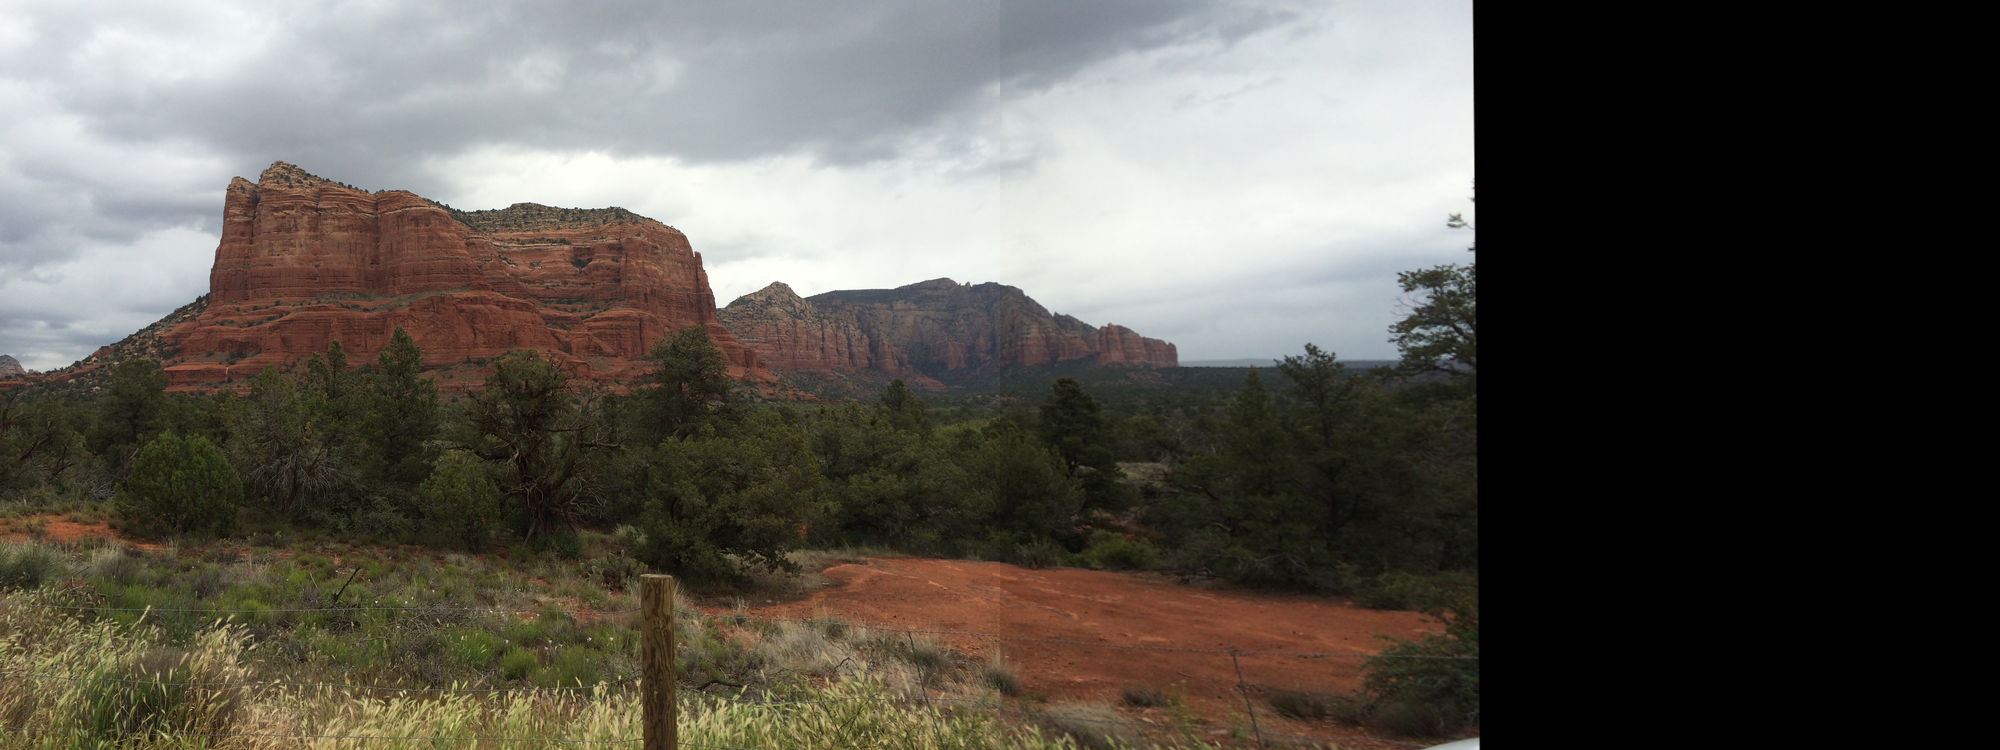

In [39]:
cv2.imwrite('result.png', result)
Image('result.png')

## Xử lý phần viền (cắt bỏ phần đen bên ngoài): có thể sử dụng lại phần trong bài thực hành trên lớp

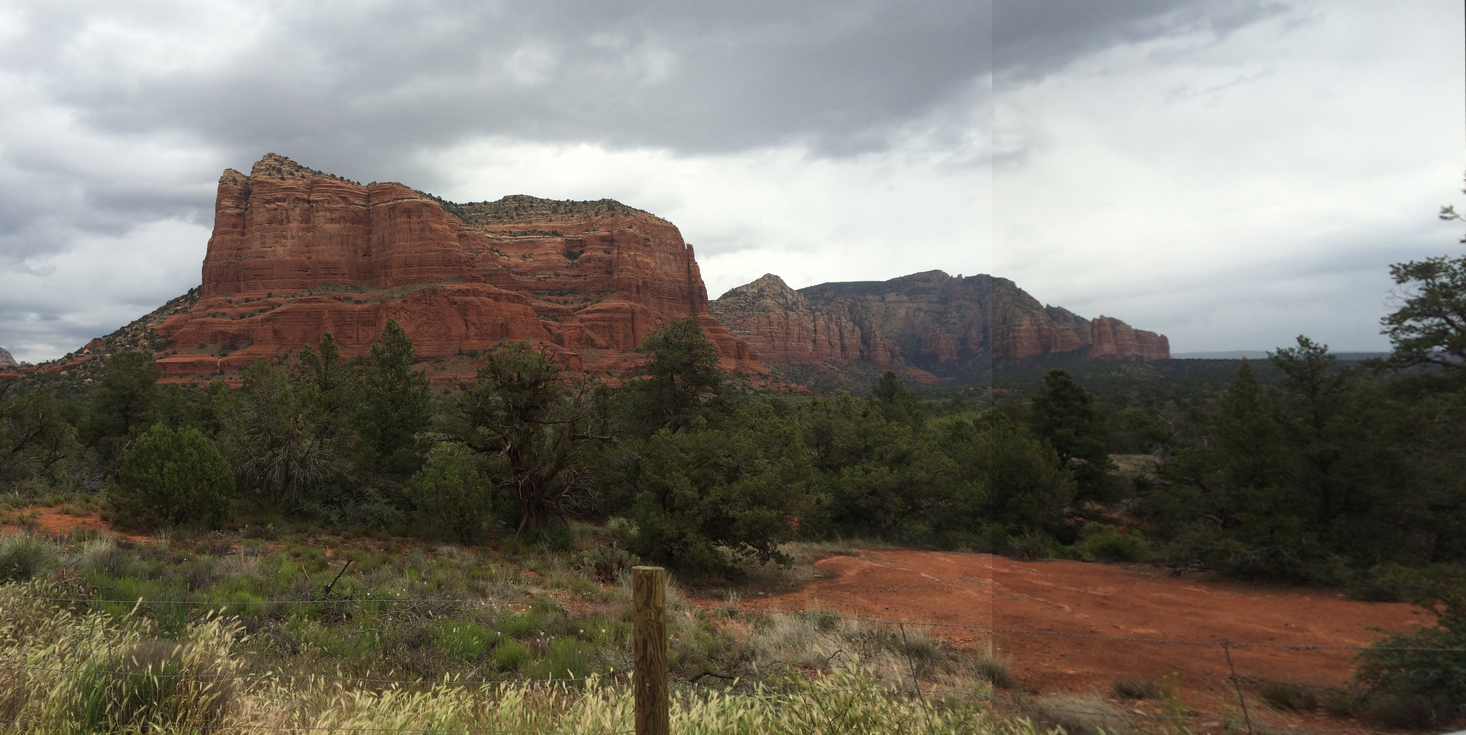

In [42]:
### YOUR CODE HERE

# create a 10 pixel border surrounding the stitched image
stitched = cv2.copyMakeBorder(result, 10, 10, 10, 10,cv2.BORDER_CONSTANT, (0, 0, 0))

# convert the stitched image to grayscale and threshold it
# such that all pixels greater than zero are set to 255
# (foreground) while all others remain 0 (background)
gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# find all external contours in the threshold image then find
# the *largest* contour which will be the contour/outline of
# the stitched image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# allocate memory for the mask which will contain the rectangular bounding box of the stitched image regi
mask = np.zeros(thresh.shape, dtype="uint8")
(x, y, w, h) = cv2.boundingRect(c)
cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

# create two copies of the mask: one to serve as our actual
# minimum rectangular region and another to serve as a counter
# for how many pixels need to be removed to form the minimum
# rectangular region
minRect = mask.copy()
sub = mask.copy()
while cv2.countNonZero(sub) > 0:
    # erode the minimum rectangular mask and then subtract
	# the thresholded image from the minimum rectangular mask
	# so we can count if there are any non-zero pixels left
    minRect = cv2.erode(minRect, None)
    sub = cv2.subtract(minRect, thresh)
    
# find contours in the minimum rectangular mask and then
# extract the bounding box (x, y)-coordinates    
cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)

# use the bounding box coordinates to extract the our final
# stitched image
stitched = stitched[y:y + h, x:x + w]

# write the output stitched image to disk
cv2.imwrite('result_fix.png', stitched)
Image('result_fix.png')

### YOUR CODE HERE

## Không bắt buộc: sinh viên tìm hiểu và thực hiện triển khai thử giải pháp để màu trên ảnh ghép được đồng nhất

Color correction, 
- ref: https://dl.acm.org/doi/abs/10.1145/1666778.1666825
- http://matthewalunbrown.com/papers/ijcv2007.pdf

Fast color transfer:
https://www.pyimagesearch.com/2014/06/30/super-fast-color-transfer-images/?fbclid=IwAR3YpTDqM3uzTZQaVstP_-AEeNUg52K1fC-1eCBSpe04MzZeIWOO2xUBz7I